# Setup

In [1]:
# Getting kaggle.json file from drive to authenticate
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! mkdir ~/.kaggle/
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
# we need this to generate images from strokes
! pip install cairocffi --quiet

     |████████████████████████████████| 88 kB 4.3 MB/s 


# Notes
#### The content is available in multiple formats.

We'll be using the Binary format and upload it to Kaggle.
When needed we can convert the binary files to images with the help of some functions defined later on.

In [3]:
import os
import random
import struct
from struct import unpack

import cairocffi as cairo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Generating Images


In [4]:
# code from https://cloud.google.com/storage/docs/access-public-data
from google.cloud import storage

# used to download the binary files from GCS public bucket
def download_public_file(bucket_name, source_blob_name, destination_fname):
    storage_client = storage.Client.create_anonymous_client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_fname)
    print('Downloaded public blob {} \n \t from bucket {} \n \t to {}'.format(
        source_blob_name, bucket.name, destination_fname
    ))

In [5]:
# create directories for saving files
base_dataset_dir = os.path.join('/content/quickdraw-binary')
if not os.path.exists(base_dataset_dir):
    os.makedirs(base_dataset_dir, exist_ok=True)

In [6]:
# download the class labels
! wget https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt

--2022-02-24 07:07:40--  https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2791 (2.7K) [text/plain]
Saving to: ‘categories.txt’

categories.txt      100%[===================>]   2.73K  --.-KB/s    in 0s      

2022-02-24 07:07:41 (10.6 MB/s) - ‘categories.txt’ saved [2791/2791]



In [7]:
# load the class labels into a list
labels = list()
with open('/content/categories.txt') as f:
    labels = f.read().splitlines()

print(f'There are {len(labels)} classes in the quickdraw dataset')

There are 345 classes in the quickdraw dataset


In [8]:
print(labels)

['aircraft carrier\n', 'airplane\n', 'alarm clock\n', 'ambulance\n', 'angel\n', 'animal migration\n', 'ant\n', 'anvil\n', 'apple\n', 'arm\n', 'asparagus\n', 'axe\n', 'backpack\n', 'banana\n', 'bandage\n', 'barn\n', 'baseball\n', 'baseball bat\n', 'basket\n', 'basketball\n', 'bat\n', 'bathtub\n', 'beach\n', 'bear\n', 'beard\n', 'bed\n', 'bee\n', 'belt\n', 'bench\n', 'bicycle\n', 'binoculars\n', 'bird\n', 'birthday cake\n', 'blackberry\n', 'blueberry\n', 'book\n', 'boomerang\n', 'bottlecap\n', 'bowtie\n', 'bracelet\n', 'brain\n', 'bread\n', 'bridge\n', 'broccoli\n', 'broom\n', 'bucket\n', 'bulldozer\n', 'bus\n', 'bush\n', 'butterfly\n', 'cactus\n', 'cake\n', 'calculator\n', 'calendar\n', 'camel\n', 'camera\n', 'camouflage\n', 'campfire\n', 'candle\n', 'cannon\n', 'canoe\n', 'car\n', 'carrot\n', 'castle\n', 'cat\n', 'ceiling fan\n', 'cello\n', 'cell phone\n', 'chair\n', 'chandelier\n', 'church\n', 'circle\n', 'clarinet\n', 'clock\n', 'cloud\n', 'coffee cup\n', 'compass\n', 'computer\n', '

In [21]:
# function to download binary files
def download_binary(class_names: list, dest_dir=None,
                        bucket_name='quickdraw_dataset'):
    assert dest_dir is not None
    assert len(class_names) > 0

    for class_name in class_names:
        blob_name = f'full/binary/{class_name}.bin'
        dest_fname = os.path.join(dest_dir, f"{class_name}.bin")
        if not os.path.exists(dest_fname):
            download_public_file(bucket_name, blob_name, dest_fname)
        else:
            pass
            # print(f'\n The file {dest_fname} already exists.')

In [23]:
# ! rm /content/quickdraw-binary/*.bin

In [25]:
# sometimes colab create a .ipynb_checkpoint directory, so check if the count is 346
print(len(os.listdir(base_dataset_dir)), 'Downloaded')

download_binary(labels, dest_dir=base_dataset_dir)

assert len(os.listdir(base_dataset_dir)) == 345
print('Success !!')

346 Downloaded


AssertionError: ignored

In [27]:
# if there are 346 files/directories in quickdraw-binary, uncomment the next command
# and run the cell
# ! rm -r /content/quickdraw-binary/.ipynb_checkpoints/
assert len(os.listdir(base_dataset_dir)) == 345
print('Success!!')

Success!!


In [28]:
# code from https://github.com/googlecreativelab/quickdraw-dataset/blob/master/examples/binary_file_parser.py
# convert binary files to strokes provided the path to the binary file
def binary_to_strokes(binary_fpath=None):
    assert binary_fpath is not None

    class_name = os.path.basename(binary_fpath)[:-4]
    data = []

    counter = 1
    with open(binary_fpath, 'rb') as f:
        while True:
            try:
                key_id, = unpack('Q', f.read(8))
                country_code, = unpack('2s', f.read(2))
                recognized, = unpack('b', f.read(1))
                timestamp, = unpack('I', f.read(4))
                n_strokes, = unpack('H', f.read(2))

                drawing = []
                for i in range(n_strokes):
                    n_points, = unpack('H', f.read(2))
                    fmt = str(n_points) + 'B'
                    x = unpack(fmt, f.read(n_points))
                    y = unpack(fmt, f.read(n_points))
                    drawing.append((x, y))
                
                vector_image = {
                    'word': class_name,
                    'country_code': country_code,
                    'recognized': recognized,
                    'timestamp': timestamp,
                    'drawing': drawing
                }
                data.append(vector_image)
            except struct.error:
                break

        counter += 1

    return data

In [29]:
# code from https://github.com/googlecreativelab/quickdraw-dataset/issues/19#issuecomment-402247262
# function to convert strokes to an image
def strokes_to_image(vector_image, side=256, line_diameter=4,
                     bg_color=(1,1,1), fg_color=(0,0,0)):
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    ctx.scale(0.9, 0.9)

    # paint background
    ctx.set_source_rgb(*bg_color)
    ctx.paint()

    # center the image
    bbox_tl = np.hstack(vector_image).min(axis=1)
    bbox_br = np.hstack(vector_image).max(axis=1)
    bbox = bbox_br - bbox_tl

    offset = ((side, side) - bbox) // 2
    offset = offset.reshape(-1, 1)
    # ceil(0.05 * 256) = 13 to account for scaling
    centered = [stroke + offset + [[13], [13]] for stroke in vector_image]

    # set brush color for strokes
    ctx.set_source_rgb(*fg_color)
    for xv, yv in centered:
        ctx.move_to(xv[0], yv[0])
        for x, y in zip(xv, yv):
            ctx.line_to(x, y)
        ctx.stroke()

    image_data = surface.get_data()
    raster_image = np.copy(np.asarray(image_data)[::4])
    return raster_image.reshape((side, side))

In [30]:
binary_fpaths = [os.path.join(base_dataset_dir, fname)
                 for fname in os.listdir(base_dataset_dir)
                 if fname.endswith('.bin')]
# See images for a random class
random_binary_fpath = random.choice(binary_fpaths)
class_label = os.path.basename(random_binary_fpath)[:-4]
print(f'Loading drawings for {class_label}')

images = binary_to_strokes(random_binary_fpath)

Loading drawings for pizza


In [31]:
type(images), len(images), type(images[0]), images[0].keys()

(list,
 130371,
 dict,
 dict_keys(['word', 'country_code', 'recognized', 'timestamp', 'drawing']))

Using random number 24896


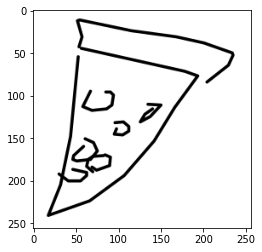

In [32]:
# let's convert one random drawing strokes to image
random_num = random.randint(0, len(images))
print(f'Using random number {random_num}')

img = strokes_to_image(images[random_num]['drawing'])
plt.imshow(img, cmap='gray')
plt.show()

# Save images to disk

In [33]:
import matplotlib.image as mpimg

In [34]:
mpimg.imsave('output.jpg', img, cmap='gray')

# Upload these binary files to kaggle

In [35]:
! kaggle datasets init -p /content/quickdraw-binary/

Data package template written to: /content/quickdraw-binary/dataset-metadata.json


In [36]:
! kaggle datasets create -p /content/quickdraw-binary/

Starting upload for file ladder.bin
100% 8.61M/8.61M [00:03<00:00, 2.93MB/s]
Upload successful: ladder.bin (9MB)
Starting upload for file traffic light.bin
100% 14.7M/14.7M [00:03<00:00, 4.93MB/s]
Upload successful: traffic light.bin (15MB)
Starting upload for file bed.bin
100% 10.5M/10.5M [00:03<00:00, 3.38MB/s]
Upload successful: bed.bin (11MB)
Starting upload for file star.bin
100% 9.40M/9.40M [00:03<00:00, 2.83MB/s]
Upload successful: star.bin (9MB)
Starting upload for file basket.bin
100% 15.7M/15.7M [00:02<00:00, 7.11MB/s]
Upload successful: basket.bin (16MB)
Starting upload for file see saw.bin
100% 9.42M/9.42M [00:03<00:00, 2.80MB/s]
Upload successful: see saw.bin (9MB)
Starting upload for file zebra.bin
100% 23.9M/23.9M [00:03<00:00, 7.02MB/s]
Upload successful: zebra.bin (24MB)
Starting upload for file mailbox.bin
100% 10.5M/10.5M [00:02<00:00, 3.71MB/s]
Upload successful: mailbox.bin (11MB)
Starting upload for file raccoon.bin
100% 23.5M/23.5M [00:04<00:00, 5.44MB/s]
Upload 